# LBF10x10-n2-f7-static-v2 Heuristic experiment analysis 

In [1]:
import copy
import os.path as osp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import posggym_agents

import baposgmcp.plot as plot_utils
import baposgmcp.plot.paper as paper_utils
from baposgmcp.config import BASE_REPO_DIR

baposgmcp_results_file = osp.join(
    BASE_REPO_DIR, "experiments", "lbf", "LBF10x10-n2-f7-static-v2", "results", "heuristic_results_v2.csv"
)
figure_dir = osp.join(BASE_REPO_DIR, "experiments", "lbf", "LBF10x10-n2-f7-static-v2", "figures")
policy_results_file = osp.join(
    posggym_agents.config.BASE_DIR, 'agents', "lbf10x10_n2_f7_static_v2", "results", "heuristic_pairwise_results.csv"
)

## Define Co-Player Prior

In [2]:
policy_prior = {1: {
    "heuristic1-v0": 1/4,
    "heuristic2-v0": 1/4,
    "heuristic3-v0": 1/4,
    "heuristic4-v0": 1/4
}}
coplayer_policy_ids = list(policy_prior[1])
print(coplayer_policy_ids)

['heuristic1-v0', 'heuristic2-v0', 'heuristic3-v0', 'heuristic4-v0']


# Problem size

- Grid size = 10 x 10
- Num food = 7
- Max agent level = 3
- Max food level = 6

**States**

```
= pos_0 * pos_1 * lvl_0 * lvl_1 * max_food_lvl**num_food x food_eaten**num_food 
= (100-7)*(99-7)*(3*3)*(6**7)*(2**7) 
= 2,759,192,543,232
```

**Actions** = 6 (Do nothing, N, S, W, E, Load)

**Observations** = 2 cells in each direction = 5x5

## The Environment

/home/jonathon/miniconda3/envs/ba-posgmcp/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


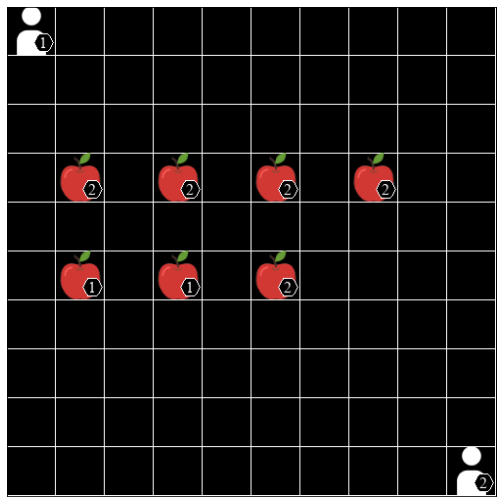

In [3]:
fig, ax = plot_utils.plot_environment("LBF10x10-n2-f7-static-v2", (9, 9))
fig.savefig(osp.join(figure_dir, "env.png"))
plt.show()

## Loading Heuristic Policy Data

In [4]:
policy_df = plot_utils.import_results(
    policy_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

fixed_policy_ids = policy_df["policy_id"].unique().tolist()
fixed_policy_ids.sort()
print("Policies")
print("--------")
for pi_id in fixed_policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in policy_df.columns:
    print("  ", c)

Policies
--------
   heuristic1-v0
   heuristic2-v0
   heuristic3-v0
   heuristic4-v0

Columns
-------
   exp_id
   agent_id
   env_id
   policy_id
   exp_seed
   num_episodes
   time_limit
   episode_return_mean
   episode_return_std
   episode_return_max
   episode_return_min
   episode_steps_mean
   episode_steps_std
   episode_time_mean
   episode_time_std
   num_episode_done
   num_LOSS
   num_DRAW
   num_WIN
   num_NA
   episode_return_CI
   episode_steps_CI
   episode_time_CI
   prop_LOSS
   prop_DRAW
   prop_WIN
   prop_NA
   num_sims
   coplayer_policy_id


### Heuristic policies pairwise performance

This is what was used to generate the meta-policies.

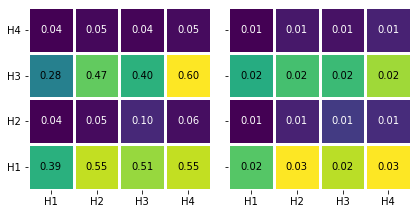

In [5]:
fig, axs = plot_utils.plot_pairwise_comparison(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(6, 3), 
    valfmt="{x:.2f}",
    policies=fixed_policy_ids,
    coplayer_policies=fixed_policy_ids,
    policy_labels={
        "heuristic1-v0": "H1",
        "heuristic2-v0": "H2",
        "heuristic3-v0": "H3",
        "heuristic4-v0": "H4"
    },
    average_duplicates=True,
    duplicate_warning=False
)
fig.savefig(osp.join(figure_dir, "fixed_policy_payoff.png"))

## Loading BAPOSGMCP Data

In [6]:
baposgmcp_df = plot_utils.import_results(
    baposgmcp_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

policy_ids = baposgmcp_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in baposgmcp_df.columns:
    print("  ", c)

Policies
--------
   POMetaRollout_greedy_numsims1000_actionselectionpucb
   POMetaRollout_greedy_numsims1000_actionselectionucb
   POMetaRollout_greedy_numsims1000_actionselectionuniform
   POMetaRollout_greedy_numsims100_actionselectionpucb
   POMetaRollout_greedy_numsims100_actionselectionucb
   POMetaRollout_greedy_numsims100_actionselectionuniform
   POMetaRollout_greedy_numsims10_actionselectionpucb
   POMetaRollout_greedy_numsims10_actionselectionucb
   POMetaRollout_greedy_numsims10_actionselectionuniform
   POMetaRollout_greedy_numsims2000_actionselectionpucb
   POMetaRollout_greedy_numsims2000_actionselectionucb
   POMetaRollout_greedy_numsims2000_actionselectionuniform
   POMetaRollout_greedy_numsims500_actionselectionpucb
   POMetaRollout_greedy_numsims500_actionselectionucb
   POMetaRollout_greedy_numsims500_actionselectionuniform
   POMetaRollout_greedy_numsims50_actionselectionpucb
   POMetaRollout_greedy_numsims50_actionselectionucb
   POMetaRollout_greedy_numsims50_act

## Combine data

In [7]:
# First need to update exp_ids of one dataframe so there are no duplicate exp_ids
df1 = baposgmcp_df
df2 = policy_df

df1_max_exp_id = df1["exp_id"].max()
if df2["exp_id"].min() <= df1_max_exp_id:
    df2["exp_id"] += df1_max_exp_id+1

combined_df = pd.concat([df1, df2]).reset_index(drop=True)

def add_alg_id(row):
    pi_id = row["policy_id"]
    if pi_id.startswith("heuristic"):
        return "fixed"
    tokens = pi_id.split("_")
    alg_id = "_".join([
        t for t in tokens 
        if all(
            s not in t for s in [
                "actionselection", "numsims", "truncated", "greedy", "softmax", "uniform", "piheuristic"
            ]
        )
    ])
    return alg_id


def add_meta_pi(row):
    pi_id = row["policy_id"]
    for meta_pi in ["greedy", "softmax", "uniform"]:
        if meta_pi in pi_id:
            return meta_pi
    return "NA"


combined_df["alg_id"] = combined_df.apply(add_alg_id, axis=1)
combined_df["meta_pi"] = combined_df.apply(add_meta_pi, axis=1)
    
policy_ids = combined_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)
    
alg_ids = combined_df["alg_id"].unique().tolist()
alg_ids.sort()
print("\nAlg IDs")
print("-------")
for n in alg_ids:
    print("  ", n)
    
print("\nMeta Pis:")
print("---------")
print(combined_df["meta_pi"].unique().tolist())

print("\nColumns")
print("-------")
for c in baposgmcp_df.columns:
    print("  ", c)

Policies
--------
   POMetaRollout_greedy_numsims1000_actionselectionpucb
   POMetaRollout_greedy_numsims1000_actionselectionucb
   POMetaRollout_greedy_numsims1000_actionselectionuniform
   POMetaRollout_greedy_numsims100_actionselectionpucb
   POMetaRollout_greedy_numsims100_actionselectionucb
   POMetaRollout_greedy_numsims100_actionselectionuniform
   POMetaRollout_greedy_numsims10_actionselectionpucb
   POMetaRollout_greedy_numsims10_actionselectionucb
   POMetaRollout_greedy_numsims10_actionselectionuniform
   POMetaRollout_greedy_numsims2000_actionselectionpucb
   POMetaRollout_greedy_numsims2000_actionselectionucb
   POMetaRollout_greedy_numsims2000_actionselectionuniform
   POMetaRollout_greedy_numsims500_actionselectionpucb
   POMetaRollout_greedy_numsims500_actionselectionucb
   POMetaRollout_greedy_numsims500_actionselectionuniform
   POMetaRollout_greedy_numsims50_actionselectionpucb
   POMetaRollout_greedy_numsims50_actionselectionucb
   POMetaRollout_greedy_numsims50_act

## Pairwise performance

Here we look at the performance of each policy against each other policy including BAPOSGMCP and baselines with different number of simulations, action selection, and meta-policies.

(<Figure size 1728x7200 with 2 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

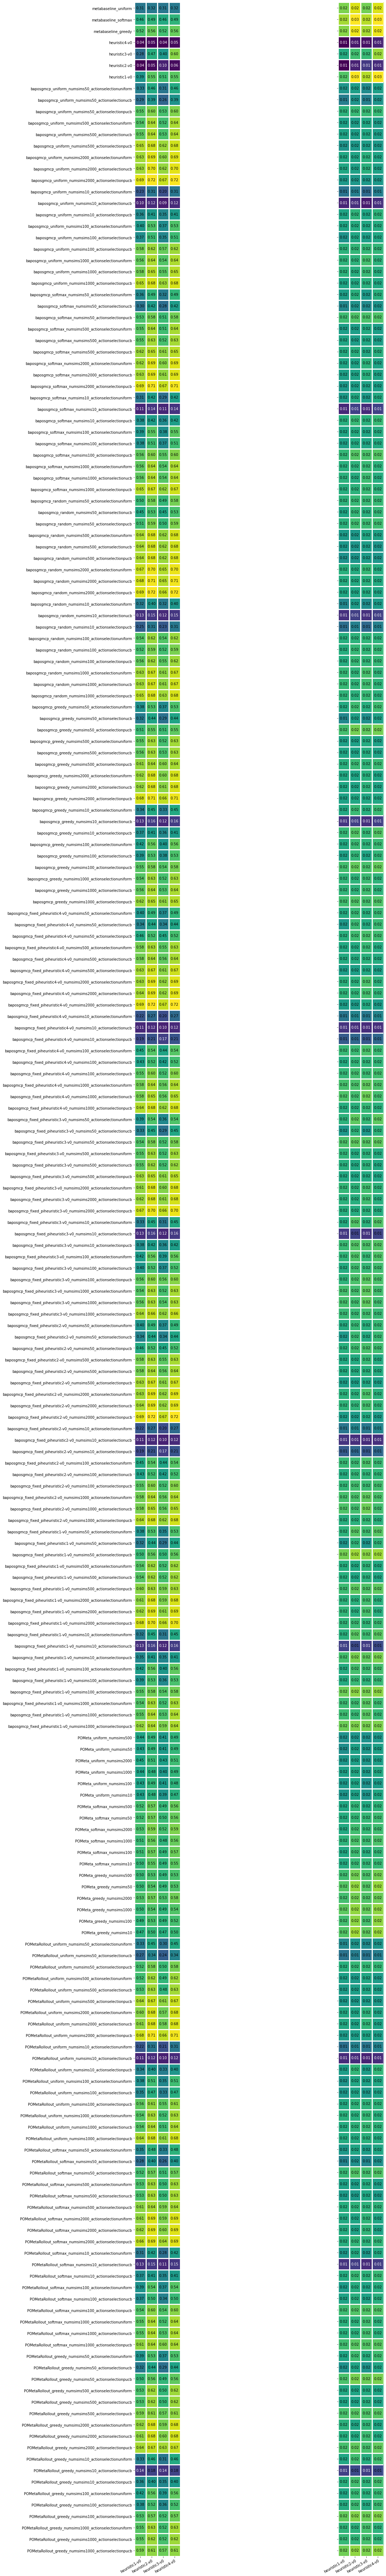

In [8]:
plot_utils.plot_pairwise_comparison(
    combined_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(24, 100), 
    valfmt="{x:.2f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

(<Figure size 1152x7200 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

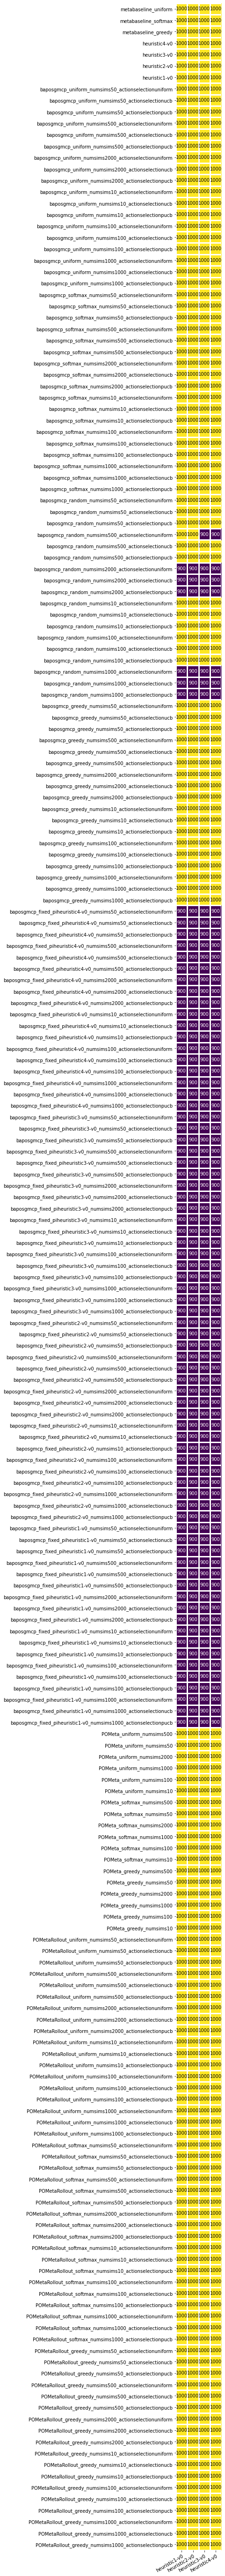

In [9]:
plot_utils.plot_pairwise_comparison(
    combined_df,
    y_key="num_episodes", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(16, 100), 
    valfmt="{x:.0f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

# Policy Prior Performance

Here we look at the expected performance against the policy prior of BAPOSGMCP.

In [10]:
exp_df = plot_utils.get_uniform_expected_df(combined_df, policy_prior)

Ungrouped size = 896
Grouped size = 223


In [11]:
# Base plot kwargs
base_plot_kwargs = paper_utils.get_base_plot_kwargs()
return_plot_kwargs = copy.deepcopy(base_plot_kwargs)
return_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Return",
    "xticks": [0, 500, 1000, 1500, 2000],
})

step_plot_kwargs = copy.deepcopy(return_plot_kwargs)
step_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Steps",
    "xticks": [0, 500, 1000, 1500, 2000],
})

## Action selection

To start we will look at the effect of action selection strategy on performanc.

We will do this by comparing the performance action selection strategies for each different meta/fixed policy, to see if there is a dominant action selection strategy.

In [12]:
exp_df["action_selection"].unique()

array(['pucb', 'ucb', 'uniform', None], dtype=object)

In [13]:
act_sel_alg_group_keys = ["alg_id", "num_sims", "action_selection"]
act_sel_alg_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
for k in act_sel_alg_group_keys:
    if k in act_sel_alg_agg_dict:
        act_sel_alg_agg_dict.pop(k)

act_sel_df = exp_df[
    (exp_df["action_selection"].isin(['pucb', 'ucb', 'uniform']))
    & (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp_fixed", "baposgmcp_random", "POMetaRollout"]))
]
gb = act_sel_df.groupby(act_sel_alg_group_keys)
gb_agg = gb.agg(**act_sel_alg_agg_dict)
act_sel_alg_df = gb_agg.reset_index()
act_sel_alg_df = act_sel_alg_df.astype({"num_sims": int})

act_sel_alg_df.sort_values(by=["alg_id", "action_selection", "num_sims"], inplace=True)

print("Ungrouped size =", len(act_sel_df))
print("Grouped size =", len(act_sel_alg_df))

act_sel_alg_ids = act_sel_alg_df["alg_id"].unique()
act_sel_alg_ids.sort()

Ungrouped size = 198
Grouped size = 72


POMetaRollout
baposgmcp
baposgmcp_fixed
baposgmcp_random


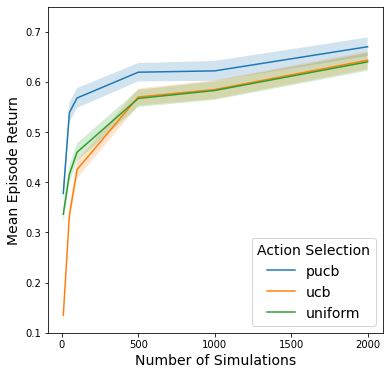

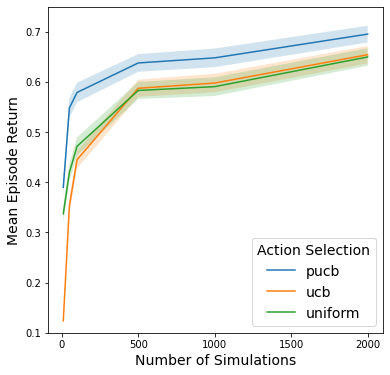

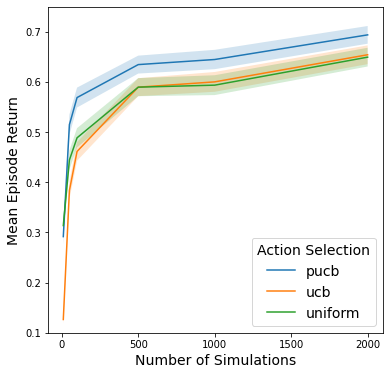

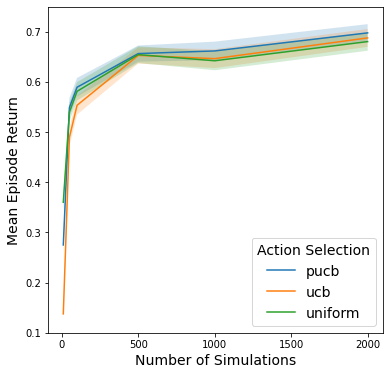

In [14]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "yticks": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    "ylim": (0.1, 0.75),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    "title": "Action Selection",  
})

for alg_id in act_sel_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_action_selection_vs_num_sims_by_alg(
        act_sel_alg_df[act_sel_alg_df["alg_id"] == alg_id],
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"act_sel_return_{alg_id}.png"))
    
del plot_kwargs

POMetaRollout
baposgmcp
baposgmcp_fixed
baposgmcp_random


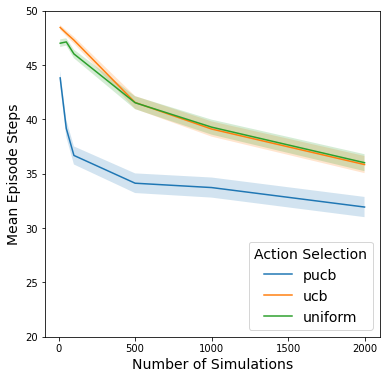

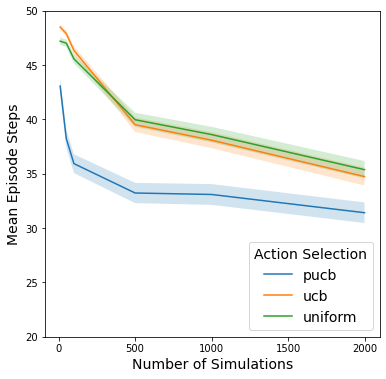

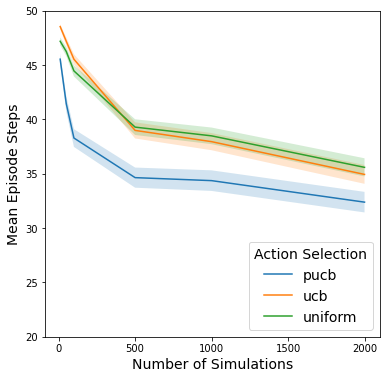

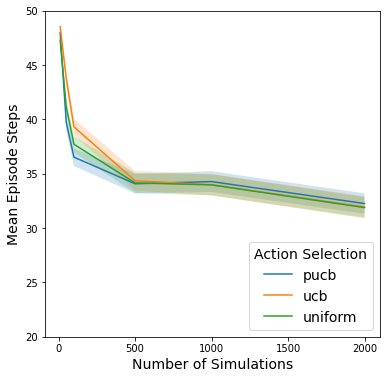

In [15]:
plot_kwargs = copy.deepcopy(step_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (20, 50),
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'lower right',
    "title": "Action Selection",  
})

for alg_id in act_sel_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_action_selection_vs_num_sims_by_alg(
        act_sel_alg_df[act_sel_alg_df["alg_id"] == alg_id],
        y_key="episode_steps_mean",
        y_err_key="episode_steps_CI",
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"act_sel_steps_{alg_id}.png"))
    
del plot_kwargs

## Comparison of the different Meta-Policies

From the above results we can see that PUCB is strictly dominant, especially for lower number of simulations.

Next we look at the effect of meta-policy. Where applicable we show performance for algorithms using PUCB only.

We create multiple plots comparing performance for the different meta-policies
Each plot is a different algorithm: BAPOSGMCP, POMetaRollout, MetaBaseline, POMeta.

In [16]:
meta_pi_label_map = {
    "greedy": r"$\sigma^{G}$",
    "softmax": r"$\sigma^{S}$",
    "uniform": r"$\sigma^{U}$",
}

meta_pi_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "POMeta", "POMetaRollout", "metabaseline"]))
    & (exp_df["action_selection"].isin(["pucb", None]))
]

meta_alg_ids = meta_pi_df["alg_id"].unique().tolist()
meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_alg_ids:
    print(n)
    
policy_ids = meta_pi_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Alg IDs
-------
POMeta
POMetaRollout
baposgmcp
metabaseline

Policy IDs
----------
POMetaRollout_greedy_numsims1000_actionselectionpucb
POMetaRollout_greedy_numsims100_actionselectionpucb
POMetaRollout_greedy_numsims10_actionselectionpucb
POMetaRollout_greedy_numsims2000_actionselectionpucb
POMetaRollout_greedy_numsims500_actionselectionpucb
POMetaRollout_greedy_numsims50_actionselectionpucb
POMetaRollout_softmax_numsims1000_actionselectionpucb
POMetaRollout_softmax_numsims100_actionselectionpucb
POMetaRollout_softmax_numsims10_actionselectionpucb
POMetaRollout_softmax_numsims2000_actionselectionpucb
POMetaRollout_softmax_numsims500_actionselectionpucb
POMetaRollout_softmax_numsims50_actionselectionpucb
POMetaRollout_uniform_numsims1000_actionselectionpucb
POMetaRollout_uniform_numsims100_actionselectionpucb
POMetaRollout_uniform_numsims10_actionselectionpucb
POMetaRollout_uniform_numsims2000_actionselectionpucb
POMetaRollout_uniform_numsims500_actionselectionpucb
POMetaRollout_uniform

POMeta
POMetaRollout
baposgmcp
metabaseline


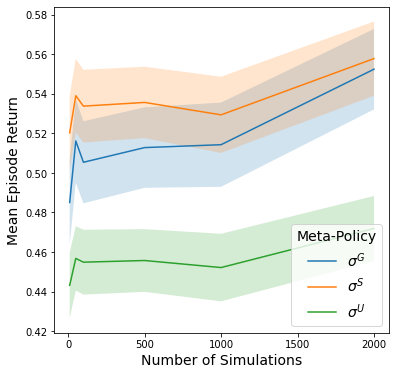

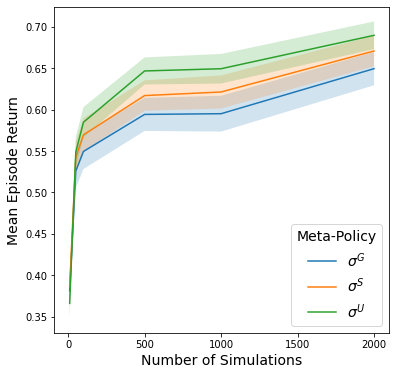

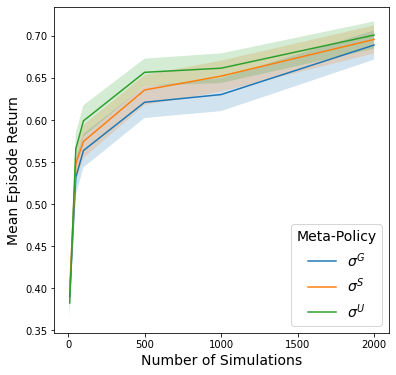

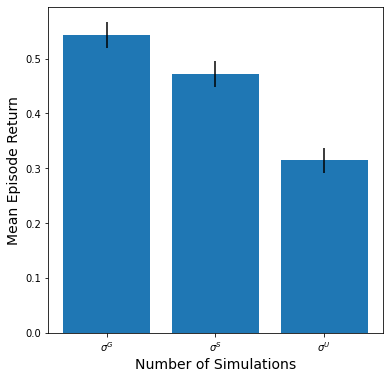

In [17]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "yticks": [0.3, 0.4, 0.5, 0.6, 0.7],
    # "ylim": (0.27, 0.75),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    "title": "Meta-Policy" 
})

for alg_id in meta_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_meta_policy_vs_num_sims(
        meta_pi_df[meta_pi_df["alg_id"] == alg_id],
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        meta_pi_label_map=meta_pi_label_map,
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"meta_pi_return_{alg_id}.png"))
    
del plot_kwargs

POMeta
POMetaRollout
baposgmcp
metabaseline


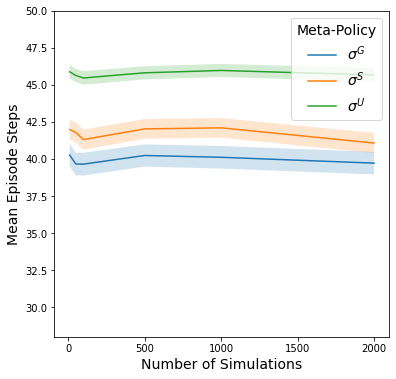

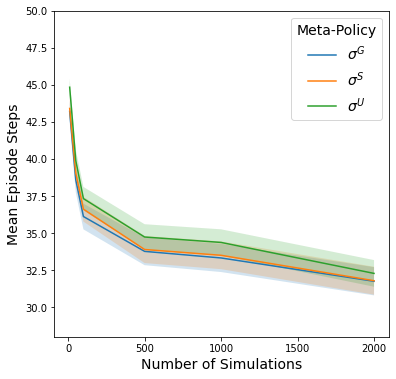

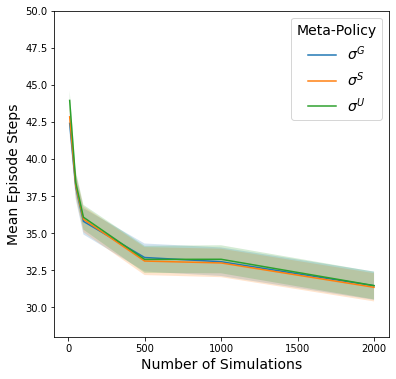

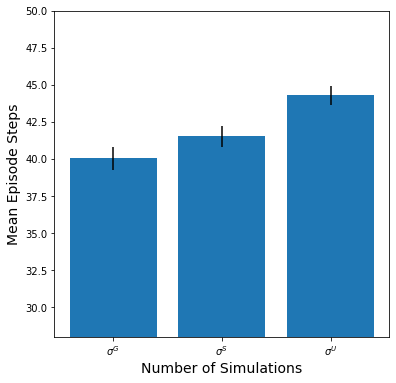

In [18]:
plot_kwargs = copy.deepcopy(step_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (28, 50),
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'upper right',
    "title": "Meta-Policy",  
})

for alg_id in meta_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_meta_policy_vs_num_sims(
        meta_pi_df[meta_pi_df["alg_id"] == alg_id],
        y_key="episode_steps_mean",
        y_err_key="episode_steps_CI",
        meta_pi_label_map=meta_pi_label_map,
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"meta_pi_steps_{alg_id}.png"))
    
del plot_kwargs

## Comparing Meta-Policy versus no meta-policy

Here we look at the performance of BAPOSGMCP (using PUCB) with using a meta-policy against not using a meta-policy (i.e. using the different fixed policies).


In [19]:
meta_vs_no_pi_label_map = {
    "baposgmcp_uniform": r"$\sigma^{U}$",
    "baposgmcp_random": "Random",
    "baposgmcp_fixed_piheuristic1-v0": "H1", 
    "baposgmcp_fixed_piheuristic2-v0": "H2", 
    "baposgmcp_fixed_piheuristic3-v0": "H3",
    "baposgmcp_fixed_piheuristic4-v0": "H4"
}

meta_vs_no_meta_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp_fixed", "baposgmcp_random"]))
    & (exp_df["action_selection"].isin(["pucb"]))
    & (exp_df["meta_pi"].isin(["uniform", "NA"]))
]

meta_vs_no_meta_alg_ids = meta_vs_no_meta_df["alg_id"].unique().tolist()
meta_vs_no_meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_vs_no_meta_alg_ids:
    print(n)
    
policy_ids = meta_vs_no_meta_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)
    
fixed_policy_ids = meta_vs_no_meta_df["fixed_policy_id"].unique().tolist()
print("\nFixed Policy IDs")
print("----------------")
for n in fixed_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp_fixed
baposgmcp_random

Policy IDs
----------
baposgmcp_fixed_piheuristic1-v0_numsims1000_actionselectionpucb
baposgmcp_fixed_piheuristic1-v0_numsims100_actionselectionpucb
baposgmcp_fixed_piheuristic1-v0_numsims10_actionselectionpucb
baposgmcp_fixed_piheuristic1-v0_numsims2000_actionselectionpucb
baposgmcp_fixed_piheuristic1-v0_numsims500_actionselectionpucb
baposgmcp_fixed_piheuristic1-v0_numsims50_actionselectionpucb
baposgmcp_fixed_piheuristic2-v0_numsims1000_actionselectionpucb
baposgmcp_fixed_piheuristic2-v0_numsims100_actionselectionpucb
baposgmcp_fixed_piheuristic2-v0_numsims10_actionselectionpucb
baposgmcp_fixed_piheuristic2-v0_numsims2000_actionselectionpucb
baposgmcp_fixed_piheuristic2-v0_numsims500_actionselectionpucb
baposgmcp_fixed_piheuristic2-v0_numsims50_actionselectionpucb
baposgmcp_fixed_piheuristic3-v0_numsims1000_actionselectionpucb
baposgmcp_fixed_piheuristic3-v0_numsims100_actionselectionpucb
baposgmcp_fixed_piheuristic3-v0_num

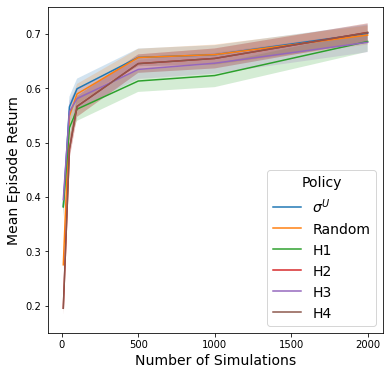

In [20]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "yticks": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    "ylim": (0.15, 0.75),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    "title": "Policy" 
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    meta_vs_no_meta_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[list(meta_vs_no_pi_label_map)],
    pi_label_map=meta_vs_no_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return.png"))
    
del plot_kwargs

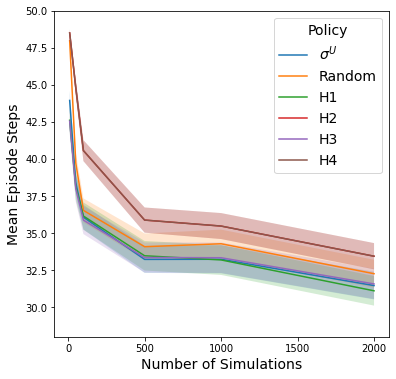

In [21]:
plot_kwargs = copy.deepcopy(step_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (28, 50),
    
})

plot_kwargs["legend_kwargs"].update({
    "loc": "upper right",
    "title": "Policy" 
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    meta_vs_no_meta_df,
    y_key="episode_steps_mean",
    y_err_key="episode_steps_CI",
    policy_prefixes=[list(meta_vs_no_pi_label_map)],
    pi_label_map=meta_vs_no_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_steps.png"))
    
del plot_kwargs

## Comparing BAPOSGMCP versus baselines

In [22]:
perf_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp_random", "POMeta", "POMetaRollout", "metabaseline"]))
    & (exp_df["action_selection"].isin(["pucb", None]))
]

policy_prefixes_to_plot = [
    "baposgmcp_uniform",
    # "baposgmcp_random",
    "POMeta_softmax",
    "POMetaRollout_uniform",
    "metabaseline_greedy"
]

baseline_pi_label_map = {
    "baposgmcp_uniform": r"BAPOSGMCP",
    "baposgmcp_random": "BAPOSGMCP Random",
    "POMeta_softmax": "POMeta", 
    "POMetaRollout_uniform": "POMetaRollout", 
    "metabaseline_greedy": "Meta-Policy",
}

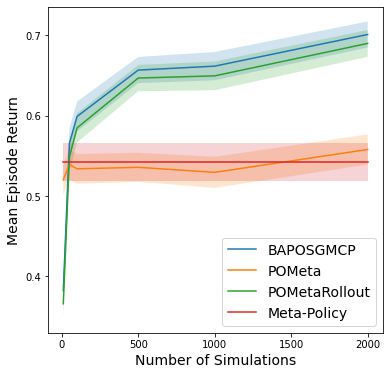

In [23]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "yticks": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    # "ylim": (0.25, 0.75),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    perf_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[policy_prefixes_to_plot],
    pi_label_map=baseline_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, "baselines_return.png"))
    
del plot_kwargs

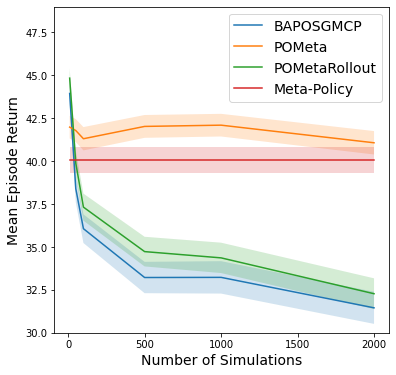

In [24]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (30, 49),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "upper right",
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    perf_df,
    y_key="episode_steps_mean",
    y_err_key="episode_steps_CI",
    policy_prefixes=[policy_prefixes_to_plot],
    pi_label_map=baseline_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, "baselines_steps.png"))
    
del plot_kwargs

## Looking at Belief accuracy by steps

- action_dist_distance
- bayes_accuracy

In [30]:
belief_df = exp_df[
    (exp_df["action_selection"].isin(['pucb', None]))
    & (
        ((exp_df["alg_id"] == "baposgmcp") & (exp_df["meta_pi"] == "uniform"))
        | ((exp_df["alg_id"] == "POMeta") & (exp_df["meta_pi"] == "softmax"))
        | ((exp_df["alg_id"] == "POMetaRollout") & (exp_df["meta_pi"] == "uniform"))
    )
]

# group over meta-policy values
belief_group_keys = ["alg_id", "num_sims"]
belief_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
for k in belief_group_keys:
    if k in belief_agg_dict:
        belief_agg_dict.pop(k)
        
gb = belief_df.groupby(belief_group_keys)
gb_agg = gb.agg(**belief_agg_dict)
belief_gb_df = gb_agg.reset_index()

belief_gb_df.sort_values(by=["alg_id", "num_sims"], inplace=True)

print("Ungrouped size =", len(belief_df))
print("Grouped size =", len(belief_gb_df))

belief_alg_ids = belief_df["alg_id"].unique().tolist()
belief_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in belief_alg_ids:
    print(n)
    
belief_policy_ids = belief_df["policy_id"].unique().tolist()
belief_policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in belief_policy_ids:
    print(n)

Ungrouped size = 18
Grouped size = 18
Alg IDs
-------
POMeta
POMetaRollout
baposgmcp

Policy IDs
----------
POMetaRollout_uniform_numsims1000_actionselectionpucb
POMetaRollout_uniform_numsims100_actionselectionpucb
POMetaRollout_uniform_numsims10_actionselectionpucb
POMetaRollout_uniform_numsims2000_actionselectionpucb
POMetaRollout_uniform_numsims500_actionselectionpucb
POMetaRollout_uniform_numsims50_actionselectionpucb
POMeta_softmax_numsims10
POMeta_softmax_numsims100
POMeta_softmax_numsims1000
POMeta_softmax_numsims2000
POMeta_softmax_numsims50
POMeta_softmax_numsims500
baposgmcp_uniform_numsims1000_actionselectionpucb
baposgmcp_uniform_numsims100_actionselectionpucb
baposgmcp_uniform_numsims10_actionselectionpucb
baposgmcp_uniform_numsims2000_actionselectionpucb
baposgmcp_uniform_numsims500_actionselectionpucb
baposgmcp_uniform_numsims50_actionselectionpucb


In [31]:
belief_plot_kwargs = copy.deepcopy(base_plot_kwargs)
belief_plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Step",
})
belief_plot_kwargs["legend_kwargs"].update({
    "loc": "upper left",
    "title": "Num. Sims." 
})

POMeta
POMetaRollout
baposgmcp


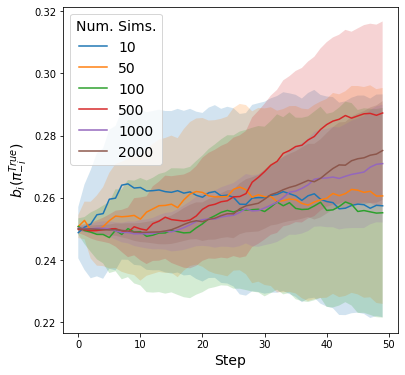

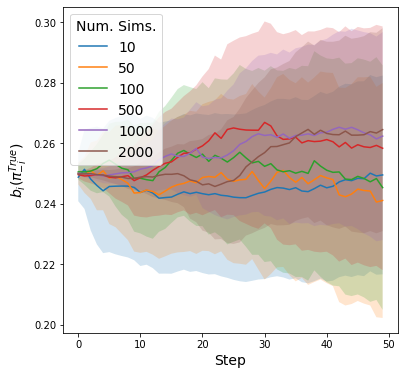

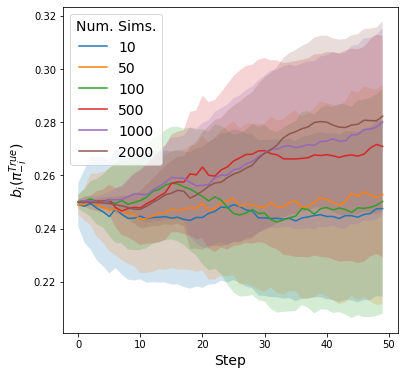

In [32]:
plot_kwargs = copy.deepcopy(belief_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": r'$b_{i}(\pi_{-i}^{True})$'
    # "ylim": (1.5, 2.3),
})

for alg_id in belief_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_belief_stats(
        belief_gb_df[belief_gb_df["alg_id"] == alg_id],
        y_key_prefix="bayes_accuracy",
        step_limit=50,
        other_agent_id=1,
        y_suffix="mean",
        y_err_suffix="CI",
        alg_id_key="alg_id",
        **plot_kwargs
    )

    fig.savefig(osp.join(figure_dir, f"bayes_accuracy_{alg_id}.png"))
    
del plot_kwargs

POMeta
POMetaRollout
baposgmcp


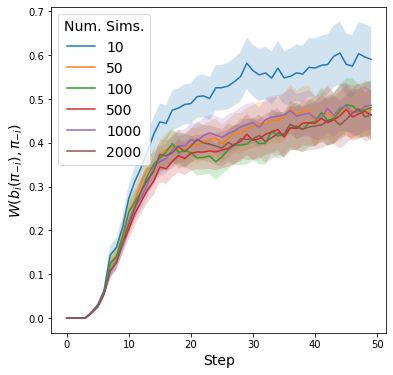

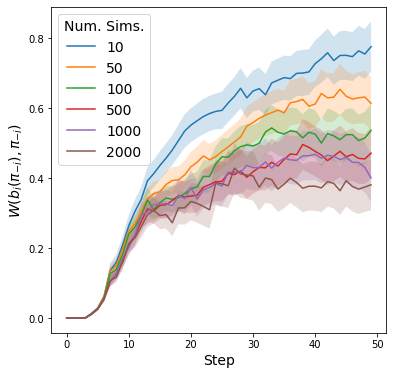

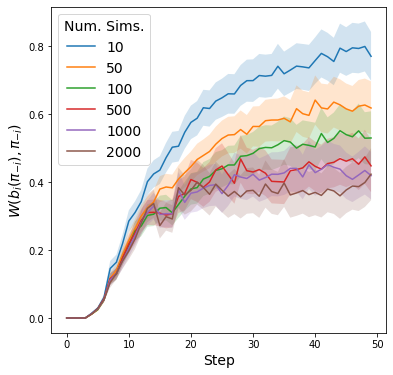

In [33]:
plot_kwargs = copy.deepcopy(belief_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": r"$W(b_{i}(\pi_{-i}), \pi_{-i})$"
    # "ylim": (1.5, 2.3),
})

belief_plot_kwargs["legend_kwargs"].update({
    "loc": "upper left",
})

for alg_id in belief_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_belief_stats(
        belief_gb_df[belief_gb_df["alg_id"] == alg_id],
        y_key_prefix="action_dist_distance",
        step_limit=50,
        other_agent_id=1,
        y_suffix="mean",
        y_err_suffix="CI",
        alg_id_key="alg_id",
        **plot_kwargs
    )

    fig.savefig(osp.join(figure_dir, f"bayes_accuracy_{alg_id}.png"))
    
del plot_kwargs

# Old stuff

Below has not been updated.

## Looking at time

   - search_time
   - update_time
   - reinvigoration_time
   - policy_calls
   - inference_time
   - search_depth

In [61]:
times_df = exp_df[
    (exp_df["action_selection"].isin(['pucb', None]))
    & (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp_fixed", "baposgmcp_random", "POMetaRollout", "POMeta"]))
]

times_group_keys = ["alg_id", "num_sims"]
times_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
for k in times_group_keys:
    if k in times_agg_dict:
        times_agg_dict.pop(k)
    
times_agg_dict["policy_id"] = pd.NamedAgg(column="policy_id", aggfunc="first")
        
gb = times_df.groupby(times_group_keys)
gb_agg = gb.agg(**times_agg_dict)
times_gb_df = gb_agg.reset_index()

times_gb_df.sort_values(by=["alg_id", "num_sims"], inplace=True)

print("Ungrouped size =", len(times_df))
print("Grouped size =", len(times_gb_df))

times_alg_ids = times_gb_df["alg_id"].unique().tolist()
times_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in times_alg_ids:
    print(n)
    
times_policy_ids = times_gb_df["policy_id"].unique().tolist()
times_policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in times_policy_ids:
    print(n)
    
    
# based on output of policy IDs (since we group IDS)
time_pi_label_map = {
    # "baposgmcp_uniform": r"BAPOSGMCP",
    # "baposgmcp_softmax": r"BAPOSGMCP",
    "baposgmcp_greedy": r"BAPOSGMCP",
    # "baposgmcp_random": "BAPOSGMCP Random",
    # "baposgmcp_fixed": "BAPOSGMCP Fixed",
    "POMeta": "POMeta", 
    "POMetaRollout": "POMetaRollout", 
    # "metabaseline": "Meta-Policy",
}

sim_policies = [
    # "baposgmcp_uniform",
    # "baposgmcp_softmax",
    "baposgmcp_greedy",
    # "baposgmcp_random",
    # "baposgmcp_fixed",
    "POMetaRollout", 
]

Ungrouped size = 84
Grouped size = 30
Alg IDs
-------
POMeta
POMetaRollout
baposgmcp
baposgmcp_fixed
baposgmcp_random

Policy IDs
----------
POMetaRollout_greedy_numsims1000_actionselectionpucb
POMetaRollout_greedy_numsims100_actionselectionpucb
POMetaRollout_greedy_numsims10_actionselectionpucb
POMetaRollout_greedy_numsims2000_actionselectionpucb
POMetaRollout_greedy_numsims500_actionselectionpucb
POMetaRollout_greedy_numsims50_actionselectionpucb
POMeta_greedy_numsims10
POMeta_greedy_numsims100
POMeta_greedy_numsims1000
POMeta_greedy_numsims2000
POMeta_greedy_numsims50
POMeta_greedy_numsims500
baposgmcp_fixed_piheuristic1-v0_numsims1000_actionselectionpucb
baposgmcp_fixed_piheuristic1-v0_numsims100_actionselectionpucb
baposgmcp_fixed_piheuristic1-v0_numsims10_actionselectionpucb
baposgmcp_fixed_piheuristic1-v0_numsims2000_actionselectionpucb
baposgmcp_fixed_piheuristic1-v0_numsims500_actionselectionpucb
baposgmcp_fixed_piheuristic1-v0_numsims50_actionselectionpucb
baposgmcp_greedy_nu

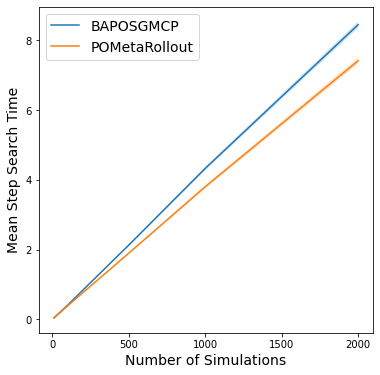

In [62]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Step Search Time",
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    times_gb_df,
    y_key="search_time_mean",
    y_err_key="search_time_CI",
    policy_prefixes=[sim_policies],
    pi_label_map=time_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, "search_time.png"))
    
del plot_kwargs

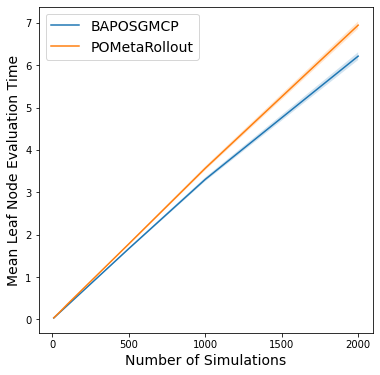

In [66]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Leaf Node Evaluation Time",
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    times_gb_df,
    y_key="evaluation_time_mean",
    y_err_key="evaluation_time_CI",
    policy_prefixes=[sim_policies],
    pi_label_map=time_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, "evaluation_time.png"))
    
del plot_kwargs

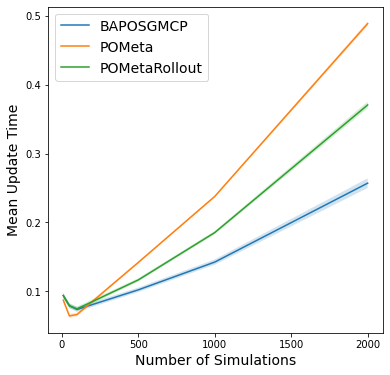

In [67]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Update Time",
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    times_gb_df,
    y_key="update_time_mean",
    y_err_key="update_time_CI",
    policy_prefixes=[list(time_pi_label_map)],
    pi_label_map=time_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, "update_time.png"))
    
del plot_kwargs

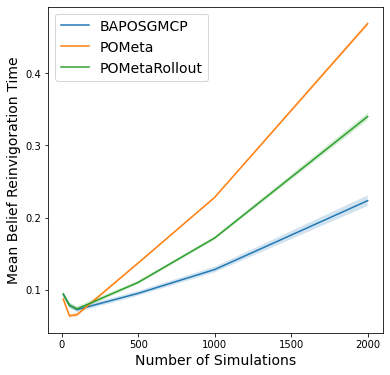

In [68]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Belief Reinvigoration Time",
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    times_gb_df,
    y_key="reinvigoration_time_mean",
    y_err_key="reinvigoration_time_CI",
    policy_prefixes=[list(time_pi_label_map)],
    pi_label_map=time_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, "update_time.png"))
    
del plot_kwargs

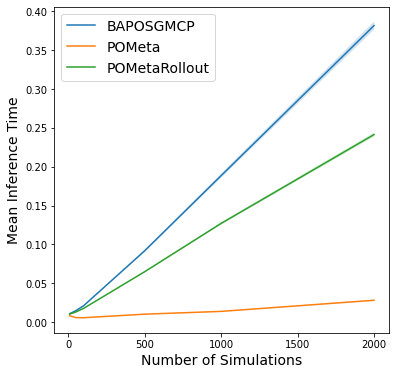

In [69]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Inference Time",
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    times_gb_df,
    y_key="inference_time_mean",
    y_err_key="inference_time_CI",
    policy_prefixes=[list(time_pi_label_map)],
    pi_label_map=time_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, "inference_time.png"))
    
del plot_kwargs

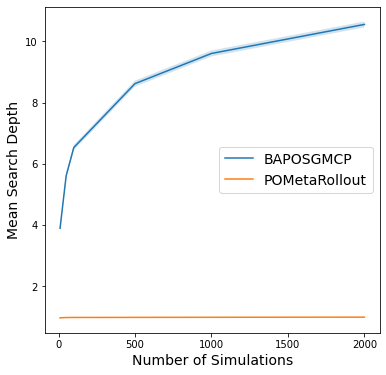

In [71]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Search Depth",
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'center right',
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    times_gb_df,
    y_key="search_depth_mean",
    y_err_key="search_depth_CI",
    policy_prefixes=[sim_policies],
    pi_label_map=time_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, "search_depth.png"))
    
del plot_kwargs